In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, contextlib
import cv2
import numpy as np
import random
import shutil
import sys
from PIL import Image
import datetime as dt
import time
import uuid

import tensorflow as tf
import tensorboard

import scipy
import scipy.io

import keras
import keras.backend as K
from keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D
from keras import Model
from keras.applications import resnet50
from keras.preprocessing import image as image_utils

import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

def supress_stdout(func):
    def wrapper(*a, **ka):
        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                func(*a, **ka)
    return wrapper

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1960279814705606111
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10775108784548991891
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Take pretrained ResNet-50 model from Keras

In [2]:
#Take pretrained model
base_model = resnet50.ResNet50(weights='imagenet')
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_____________________________________

so, the base model works. now for the face data:

-80% train, 20% validation split

-No other image augmentation

In [3]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=0, 
    width_shift_range=0.0, 
    height_shift_range=0.0, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    channel_shift_range=0.0, 
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=False, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=resnet50.preprocess_input, 
    data_format=None, 
    validation_split=0.2, 
    dtype=None)

car_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=0, 
    width_shift_range=0.0, 
    height_shift_range=0.0, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    channel_shift_range=0.0, 
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=False, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=resnet50.preprocess_input, 
    data_format=None, 
    validation_split=0.2, 
    dtype=None)

Append random string to filename of all images in dataset to ensure random <code>flow_from_directory()</code> order / training order

In [4]:
for base, dirs, files in os.walk('Z:\FaceDataR'): 
    for filename in files:
        dst = str(uuid.uuid4())+'$'+str.split(filename, '$')[-1]
        
        src = os.path.join(base, filename)
        dst = os.path.join(base, dst)

        os.rename(src, dst)

Batch size: 20
Image size: 244x244px

In [5]:
BS = 20

train_it = datagen.flow_from_directory('Z:\FaceDataR', class_mode = 'categorical', batch_size=BS, target_size=(224,224), shuffle=True, subset='training', seed=42)
val_it = datagen.flow_from_directory('Z:\FaceDataR', class_mode='categorical', batch_size=BS, target_size=(224,224), shuffle=False, subset='validation')

car_train_it = car_datagen.flow_from_directory('Z:\CarData', class_mode='categorical', batch_size=BS, target_size=(224,224), subset='training')
car_val_it = car_datagen.flow_from_directory('Z:\CarData', class_mode='categorical', batch_size=BS, target_size=(224,224), subset='validation')


Found 1212 images belonging to 101 classes.
Found 303 images belonging to 101 classes.
Found 804 images belonging to 67 classes.
Found 201 images belonging to 67 classes.


exemplar: 000\1f2b1f46-9c60-482d-8112-5b6ffa8a9ccc$0_f_-105.resample.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


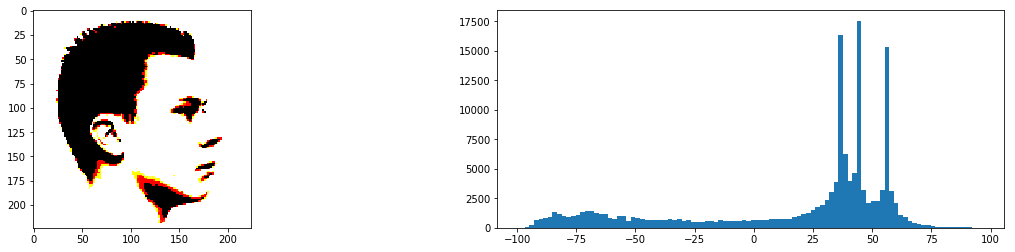

In [6]:
print("exemplar:", train_it.filenames[0])
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.imshow(train_it[0][0][0,:,:,:])
plt.subplot(1,2,2)
plt.hist(train_it[0][0][0,:,:,:].ravel(), bins=100);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


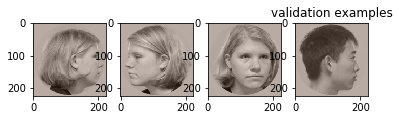

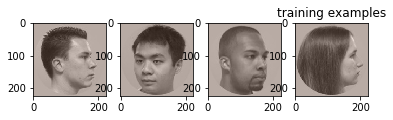

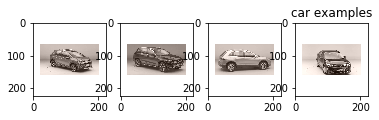

In [7]:
fig, subs = plt.subplots(1,4)
plt.title("validation examples")
for i in range(4):
    subs[i].imshow(val_it[0][0][i,:,:,:]/255 + 0.5)

fig, subs = plt.subplots(1,4)
plt.title("training examples")
for i in range(4):
    subs[i].imshow(train_it[0][0][i,:,:,:]/255 + 0.5)

fig, subs = plt.subplots(1,4)
plt.title("car examples")
for i in range(4):
    subs[i].imshow(car_train_it[0][0][i,:,:,:]/255 + 0.5)


In [8]:
#Take pretrained model, without last fc layer this time
#bless u https://stackoverflow.com/questions/52282108/keras-accuracy-drops-while-finetuning-inception
K.set_learning_phase(0)

base_model = resnet50.ResNet50(weights='imagenet', include_top=False, pooling = 'avg')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
predictions = Dense(101, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(x) 
model2 = Model(inputs=base_model.input, outputs=predictions)
mpool = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

K.set_learning_phase(1)

model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
#tbcallback = keras.callbacks.TensorBoard(
#    log_dir='./log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"-catxeloss-catacc-lr01-m09"), 
#    histogram_freq=0, 
#    batch_size=BS, 
#    write_graph=False, 
#    write_grads=False, 
#    write_images=False, 
#    embeddings_freq=0, 
#    embeddings_layer_names=None, 
#    embeddings_metadata=None, 
#    embeddings_data=None, 
#    update_freq='epoch')

cpcb = keras.callbacks.ModelCheckpoint(
    './checkpoints/weights.{}.hdf5'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"-catxeloss-catacc-lr01-m09_sgd-LPHASE"), 
    monitor='val_categorical_accuracy', verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    period=5)

base_model = None

In [ ]:
#optimization
#adam = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

#metrics
def true(y_true, y_pred):
    return tf.argmax(y_true)
def pred(y_true, y_pred):
    return tf.argmax(y_pred)

mx_opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0, nesterov=True)

model2.compile(optimizer = mx_opt, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

#training
history = model2.fit_generator(
    train_it,
    steps_per_epoch = train_it.samples // BS,
    validation_data = val_it, 
    validation_steps = val_it.samples // BS,
    epochs = 15,
    callbacks = [ reduce_lr, cpcb ])

In [ ]:
#model2.compile(optimizer = mx_opt, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
results = model2.evaluate_generator(
    train_it, 
    steps=50, 
    max_queue_size=10, 
    workers=1, 
    use_multiprocessing=False, 
    verbose=1)

print('loss, acc:', results)

In [ ]:
print(history.history.keys())

In [ ]:
#plot history
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print(history.history.keys())

Examine predictions on face images to confirm the identities have been learned

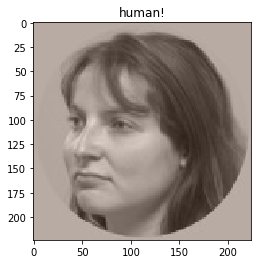

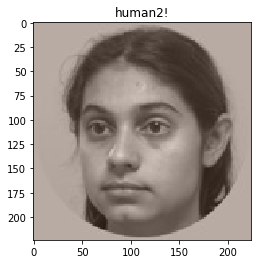

In [9]:
batch = train_it.next()

image=batch[0][0]
plt.figure()
plt.imshow(image/255 + 0.5)
plt.title('human!')

image2=batch[0][6]
plt.figure()
plt.imshow(image2/255 + 0.5)
plt.title('human2!');

In [10]:
model2.load_weights("./checkpoints/weights.2019-06-02-15-32-56-catxeloss-catacc-lr01-m09_sgd-LPHASE.hdf5")
preds = model2.predict(batch[0])

targets shape (20, 101)
Human 1 Correct: 25
Human 2 Correct: 4
input shape (20, 224, 224, 3) output shape (20, 101)
Human 1 Predicted: 25
Human 2 Predicted: 4


Text(0.5, 1.0, 'true class distribution in batch')

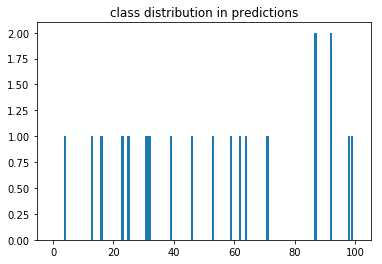

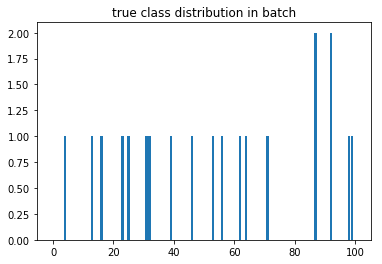

In [11]:
print('targets shape', batch[1].shape)
print('Human 1 Correct:', np.argmax(batch[1][0]))
print('Human 2 Correct:', np.argmax(batch[1][6]))

print('input shape',batch[0].shape,'output shape',preds.shape)

arr = np.zeros(101)
arr2 = np.zeros(101)
for i in range(len(batch[0])):
    arr[np.argmax(preds[i])] += 1
    arr2[np.argmax(batch[1][i])] += 1

#print(batch[1][0], np.argmax((preds[0])))
#print(np.argsort(preds))

print('Human 1 Predicted:', np.argmax(preds[0]))
print('Human 2 Predicted:', np.argmax(preds[6]))

#print(np.average(keras.metrics.categorical_accuracy(batch[1],preds)))
#print(keras.metrics.categorical_accuracy(batch[1],preds))

plt.bar(np.arange(101),arr)
plt.title("class distribution in predictions")
plt.figure()
plt.bar(np.arange(101),arr2)
plt.title("true class distribution in batch")

In [12]:
mx_opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0, nesterov=True)
model2.compile(optimizer = mx_opt, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

results = model2.evaluate_generator(
    val_it, 
    steps=50, 
    max_queue_size=10, 
    workers=1, 
    use_multiprocessing=False, 
    verbose=1)

print('loss, acc:', results)

50/50 [==============================] - 18s 369ms/step
loss, acc: [1.4872685547749285, 0.946259214955964]


In [ ]:
print(batch[0][np.newaxis,0,...].shape)

Relevance / Saliency mapping of results

Use front-view faces only for relevance, so that psych baseline is applicable

In [13]:
front_view_filenames = []
front_view_classes = []
for base, dirs, files in os.walk('Z:FaceDataCp/'): 
    for filename in files:
        if "000." in filename or "_0." in filename:
            front_view_filenames.append(base+"/"+filename)

In [14]:
len(front_view_filenames)

101

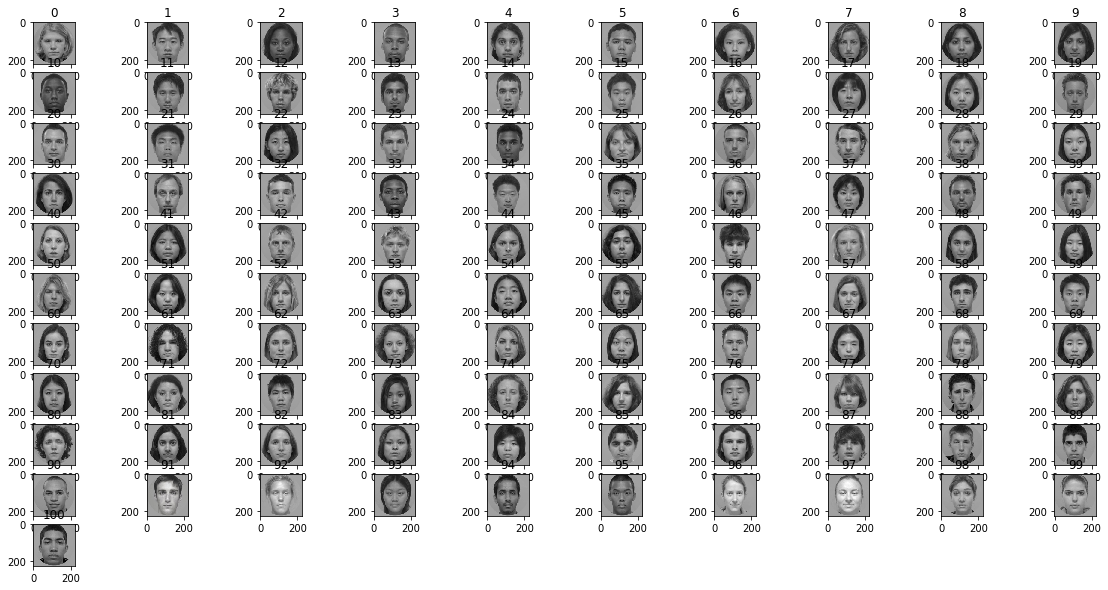

In [104]:
batch = np.zeros((101,224,224,3))
plt.figure(figsize=(20,10))
for i in range(len(front_view_filenames)):
    filename = front_view_filenames[i]
    image = image_utils.load_img(filename,target_size=(224, 224))
    x = image_utils.img_to_array(image)
    batch[i] = x
    plt.subplot(11,10,i+1)
    plt.imshow(batch[i]/255)
    plt.title(i)
    
batch = resnet50.preprocess_input(batch)

In [105]:
print(batch.shape)

(101, 224, 224, 3)


custom lrp

In [106]:
#calculate EVERY LAYERS outputs
def run_all_layers(batch, model):

    outputs_ph = [layer.output for layer in model.layers[1:]]          # all layer outputs
    inputs_ph = [layer.input for layer in model.layers[1:]] 
    
    # Testing
    m = keras.models.Model(inputs=model2.input, outputs=outputs_ph)
    return [batch]+m.predict(batch)  

#put the dicts in the global namespace
weights_dict = {}
outputs_dict = {}
inputs_dict = {}
layers_dict = {}
relevances_dict = {}

#turn values from arrays into dictionaries'
def prepareDictionaries(outputs, weights):
    weights_dict.clear()
    outputs_dict.clear()
    inputs_dict.clear()
    layers_dict.clear()
    relevances_dict.clear()
    for i in range(len(outputs)):
        name = model2.layers[i].name
        outputs_dict[name] = outputs[i]
        weights_dict[name] = weights[i]
        if (type(model2.layers[i].input) != list):
            inputs_dict[name] = model2.layers[i].input.name.split("/")[0]
            if (":" in inputs_dict[name] or "branch" in inputs_dict[name] or "_pad" in inputs_dict[name] or "bn_" in inputs_dict[name] or "conv1_1" in inputs_dict[name]):
                inputs_dict[name] = inputs_dict[name][0:-2]
        else:
            input_names = []
            for inp in model2.layers[i].input:
                n = inp.name.split("/")[0]
                if ("branch" in n):
                    n = n[0:-2]
                input_names += [n]

            inputs_dict[name] = input_names

        layers_dict[name] = model2.layers[i]
        relevances_dict[name] = np.zeros_like(outputs[i])
    return weights_dict,outputs_dict,inputs_dict,layers_dict,relevances_dict

In [122]:
#handy visualizer of graph
def print_shapes(model):
    for i in range(len(model.layers)):
        print("layer:",model.layers[i].name)
        if (len(weights_dict[model.layers[i].name])!=0):
            print('    has weights:')
            for w in weights_dict[model.layers[i].name]:
                print('    ',w.shape)
        else: print('    no weights')
    
        if (len(outputs_dict[model.layers[i].name])!=0):
            print('    has outputs:')
            print('    ',outputs_dict[model.layers[i].name].shape)
            
        if (type(inputs_dict[model.layers[i].name]) != list):
            print('    input name:', inputs_dict[model.layers[i].name])
        else:
            for n in range(len(inputs_dict[model.layers[i].name])):
                print('    input',n+1,'name:',(inputs_dict[model.layers[i].name][n]))
    
#print_shapes(model2)

#create LRP backwards pass rule for every layer in this mf

#top dense layer
def LRPDense(inputs,weights,previous_relevances):
    relevances = np.zeros_like(inputs)
    #zijs
    preactivations = np.diag(inputs[0,:]).dot(weights[0])
    
    #split into positive and negative components
    preactivations_p = np.maximum(0,preactivations)
    preactivations_n = np.minimum(0,preactivations)
    
    preactivation_sums_p = np.sum(preactivations_p, axis=0) + np.maximum(0,weights[1])
    preactivation_sums_n = np.sum(preactivations_n, axis=0) + np.minimum(0,weights[1])
    
    preactivation_fraction_p = 0.5 * (preactivations_p / preactivation_sums_p)
    preactivation_fraction_n = 0.5 * (preactivations_n / preactivation_sums_n)
    
    preactivation_fraction_p = np.where(np.isfinite(preactivation_fraction_p), preactivation_fraction_p, 0)
    preactivation_fraction_n = -np.where(np.isfinite(preactivation_fraction_n), preactivation_fraction_n, 0)
    
    relevance_messages = (preactivation_fraction_n * previous_relevances) + (preactivation_fraction_p * previous_relevances)
    relevances = relevance_messages.sum(axis=1)
    return relevances

#max-pooling layer
def LRPMaxPool2D(inputs,previous_relevances,padding,stride,poolsize):    
    if 'valid' in padding:
        padding = 0
    else:
        if inputs.shape[1]%stride[0] == 0:
            padding=np.maximum(kernels[0].shape[0] - stride[0],0)
        else:
            padding=np.maximum(kernels[0].shape[0] - (inputs.shape[1]%stride[0]),0)
    
    relevance = np.zeros_like(inputs)
    
    #relprop for each channel to its RF
    for i in range(previous_relevances.shape[3]):
        for a in range(previous_relevances.shape[1]):
            for b in range(previous_relevances.shape[2]):
                tpixels = np.sum(np.ones(poolsize))
                c = (padding)+(stride[0])*(a)
                d = (padding)+(stride[1])*(b)
                
                relevance[...,c:c+poolsize[0],d:d+poolsize[1],i] += previous_relevances[0,a,b,i]/tpixels

    return relevance

#global average-pooling layer
def LRPGlobAvgPool2D(inputs,previous_relevances):
    relevances = np.zeros_like(inputs)
    print(np.isfinite(previous_relevances).all())
    
    for m in range(inputs.shape[-1]) :
        relevances[:,:,:,m] = previous_relevances[...,m]/np.sum(np.ones_like(inputs[:,:,:,m]))
        relevances[:,:,:,m] = np.where(np.isfinite(relevances[:,:,:,m]), relevances[:,:,:,m], 0)

    return relevances

#simple activation layer
def LRPActivation(previous_relevances):
    return previous_relevances

#adding layer, need to branch the recursion here!
def LRPAdd(activations,inputs,weights,previous_relevances):
    #find the inputs being added
    print("    branching relevance to",inputs[0],"and",inputs[1])
    
    sums = np.abs(outputs_dict[inputs[0]]) + np.abs(outputs_dict[inputs[1]])
    
    relevance_per_branch = []
    for input_name in inputs:
        relevance_per_branch.append(previous_relevances*(np.abs(outputs_dict[input_name])/sums))
    
    return relevance_per_branch

#batchnorm layer
def LRPBatchNormV1(inputs,weights,previous_relevances):
    return previous_relevances

def LRPGenConv(inputs, kernels, previous_relevances, activations, stride, padding):
    
    print("input:",inputs.shape)
    for kern in kernels:
        print('    kernel:',kern.shape)
    print(previous_relevances.shape)
    
    if 'valid' in padding:
        padding = 0
    else:
        if inputs.shape[1]%stride[0] == 0:
            padding=np.maximum(kernels[0].shape[0] - stride[0],0)
        else:
            padding=np.maximum(kernels[0].shape[0] - (inputs.shape[1]%stride[0]),0)
    
    relevance = np.zeros((inputs.shape[0],inputs.shape[1]+(2*padding),inputs.shape[2]+(2*padding),inputs.shape[3]))
    inp_pad = np.zeros((inputs.shape[0],inputs.shape[1]+(2*padding),inputs.shape[2]+(2*padding),inputs.shape[3]))
    
    if padding>0:
        inp_pad[0,padding:-padding,padding:-padding,:] = inputs
    else:
        inp_pad=inputs
    
    #relprop for each kernel to its RF
    for i in range(previous_relevances.shape[3]):
        for a in range(previous_relevances.shape[1]):
            for b in range(previous_relevances.shape[2]):
                trel = previous_relevances[0,a,b,i]
                c = (padding)+(stride[0])*(a)
                d = (padding)+(stride[1])*(b)
                rf = inp_pad[...,c:c+kernels[0].shape[0],d:d+kernels[0].shape[1],:]
                
                preactivations = rf * kernels[0][0,:,:,i]
                preactivations_p = np.maximum(0,preactivations)
                preactivations_n = np.minimum(0,preactivations)
                
                preactivation_sum_p = np.sum(preactivations_p) + np.maximum(0,kernels[1][i])
                preactivation_sum_n = np.sum(preactivations_n) + np.minimum(0,kernels[1][i])
                
                rel_fractions_p = 0.5 * (preactivations_p / preactivation_sum_p)
                rel_fractions_n = 0.5 * (preactivations_n / preactivation_sum_n)
                
                rel_fractions_p = np.where(np.isfinite(rel_fractions_p), rel_fractions_p, 0)
                rel_fractions_n = -np.where(np.isfinite(rel_fractions_n), rel_fractions_n, 0)
                
                relevance[...,c:c+kernels[0].shape[0],d:d+kernels[0].shape[1],:] += (trel * rel_fractions_p) + (trel * rel_fractions_n)
                
                #if this is a downsampling conv, interpolate
                if (stride[0]==2 and kernels[0].shape[0]==1): 
                    for x in range(2):
                        for y in range(2):
                            if (x,y)==(0,0):
                                continue
                            relevance[...,c+x,d+y,:]=relevance[...,c,d,:]
                        
                        
    print(relevance.shape)
    if padding>0:
        return relevance[...,padding:-padding,padding:-padding,:]
    else:
        return relevance
    
def LRPPadding(inputs, previous_relevances, padding):
    top=padding[0][0]
    bottom=padding[0][1]
    left=padding[1][0]
    right=padding[1][1]
    
    return previous_relevances[:,top:-bottom,left:-right,:]
                                  
#Recursive LRP calculation starting at layer "name" and using the "relevances" dict
@supress_stdout
def LRP(name, rel, ceaseOnActivation=False, ceaseTarget=None, ceaseRel=None):
    print('Propagating relevance from \033[1m',name, "\033[0mto\033[1m", inputs_dict[name],"\033[0m")
    if (ceaseOnActivation and "activation" in name):
        print("    Reached activation. Ending this branch and merging.")
        return LRP(ceaseTarget,ceaseRel,False,None,None)
    
    if (rel==0).all():
        print('    Empty.')
        return rel
    
    if ("dense" in name):
        print('    Detected FC layer...')
        rel = LRPDense(outputs_dict[inputs_dict[name]],weights_dict[name],rel)
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("max_pool" in name):
        print("    Detected max_pool layer...")
        rel = LRPMaxPool2D(outputs_dict[inputs_dict[name]],rel,layers_dict[name].get_config()["padding"], layers_dict[name].get_config()["strides"], layers_dict[name].get_config()["pool_size"])
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("global_average_pooling2d" in name):
        print("    Detected globalAVGpool layer...")
        rel = LRPGlobAvgPool2D(outputs_dict[inputs_dict[name]],rel)
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("activation" in name):
        print("    Detected activation layer... (and picking up any residue)")
        rel = LRPActivation(relevances_dict[name])
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("add" in name):
        print("    Detected add layer...")
        rel = LRPAdd(outputs_dict[name],inputs_dict[name],weights_dict[name],rel)
        
        for i in range(len(inputs_dict[name])):
            relevances_dict[inputs_dict[name][i]] += rel[i]
    
    elif ("bn" in name):
        print("    Detected BatchNorm layer...")
        relevances_dict[inputs_dict[name]] += LRPBatchNormV1(outputs_dict[inputs_dict[name]],weights_dict[name],rel)
    
    elif ("res" in name or name=="conv1"):
        print("    Detected conv layer...")
        rel = LRPGenConv(outputs_dict[inputs_dict[name]],weights_dict[name],rel, outputs_dict[name], layers_dict[name].get_config()["strides"], layers_dict[name].get_config()["padding"])
        relevances_dict[inputs_dict[name]] += rel
    
    elif ("_pad" in name):
        print("    Detected padding layer...")
        rel = LRPPadding(inputs_dict[name],rel,layers_dict[name].get_config()["padding"])
        relevances_dict[inputs_dict[name]] += rel
        
    elif ("input" in name):
        print("--reached input layer!")
        return
    
    else:
        print("!no LRP method known for",name,"!")
        return(rel)
    
    if (type(inputs_dict[name]) != list):
        print('    Done. Total relevance sent:',np.sum(np.abs(rel)))
        print()
        return LRP(inputs_dict[name], rel, ceaseOnActivation, ceaseTarget, ceaseRel)
    else:
        print('    Done. Total relevance sent:',np.sum(np.abs(rel[0]))+np.sum(np.abs(rel[1])))
        print()
        return LRP(inputs_dict[name][0], rel[0], True, inputs_dict[name][1], rel[1])


In [123]:
#prepares values needed for lrp, then runs
def relevanceMap(b):
    relevance_maps = []
    for i in range(len(b)):
        print("Analysing image",i+1,"of",len(b),"...")
        outputs = run_all_layers(b[i:i+1], model2)
        weights = [layer.get_weights() for layer in model2.layers]
        weights_dict,outputs_dict,inputs_dict,layers_dict,relevances_dict = prepareDictionaries(outputs, weights) 

        output_name = model2.layers[-1].name
        first_rel = np.where(outputs[-1]==outputs[-1].max(), 1, 0)
        relevances_dict[output_name] = first_rel

        #run recursive lrp (can't handle >1 images at a time yet)
        start = time.time()
        LRP(output_name, first_rel)
        end = time.time()
        
        print("ETA:",str(time.ctime(int(time.time()+((len(b)-i-1)*(end-start))))))

        relevance_maps.append(relevances_dict["input_2"])

    return relevance_maps

Run custom LRP on all 101 images. Runtime: ~6hrs. Saves maps to files in <code>./relevances/*.npz</code> so I never have to do this again...

In [124]:
relevances = relevanceMap(batch)

Analysing image 1 of 101 ...


c:\users\jnani\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
c:\users\jnani\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


ETA: Sun Aug 25 01:45:57 2019
Analysing image 2 of 101 ...
ETA: Sun Aug 25 01:48:06 2019
Analysing image 3 of 101 ...
ETA: Sun Aug 25 01:39:31 2019
Analysing image 4 of 101 ...
ETA: Sun Aug 25 01:47:41 2019
Analysing image 5 of 101 ...
ETA: Sun Aug 25 01:48:53 2019
Analysing image 6 of 101 ...
ETA: Sun Aug 25 01:51:07 2019
Analysing image 7 of 101 ...
ETA: Sun Aug 25 01:49:46 2019
Analysing image 8 of 101 ...
ETA: Sun Aug 25 01:48:54 2019
Analysing image 9 of 101 ...
ETA: Sun Aug 25 01:49:31 2019
Analysing image 10 of 101 ...
ETA: Sun Aug 25 01:48:40 2019
Analysing image 11 of 101 ...
ETA: Sun Aug 25 01:49:03 2019
Analysing image 12 of 101 ...
ETA: Sun Aug 25 01:49:42 2019
Analysing image 13 of 101 ...
ETA: Sun Aug 25 01:50:37 2019
Analysing image 14 of 101 ...
ETA: Sun Aug 25 01:51:08 2019
Analysing image 15 of 101 ...
ETA: Sun Aug 25 01:50:16 2019
Analysing image 16 of 101 ...
ETA: Sun Aug 25 01:50:55 2019
Analysing image 17 of 101 ...
ETA: Sun Aug 25 01:43:44 2019
Analysing image 18

In [125]:
for i in range(len(relevances)):
    np.savez("./relevances_bugfix/rmap"+str(i)+".npz", relevances[i])

Load 101 maps from files

In [126]:
rs = []
for i in range(101):
    rs.append(list(np.load("./relevances_bugfix/rmap"+str(i)+".npz").values())[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


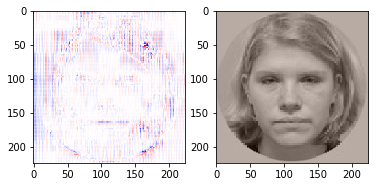

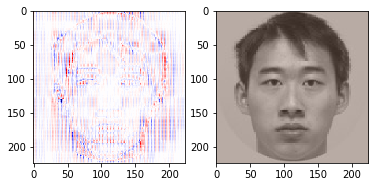

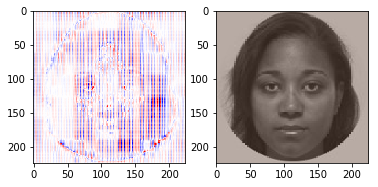

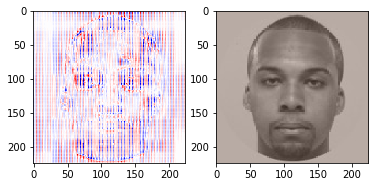

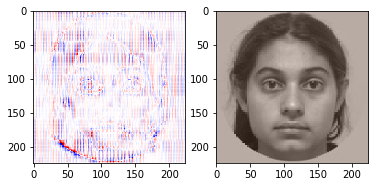

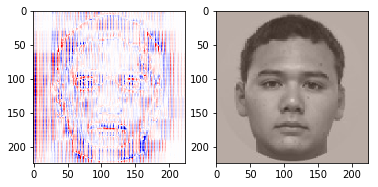

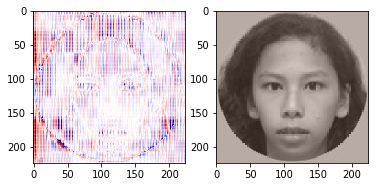

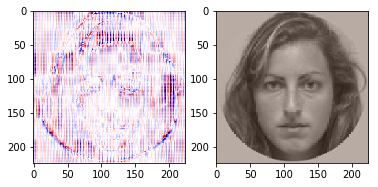

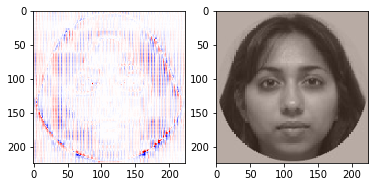

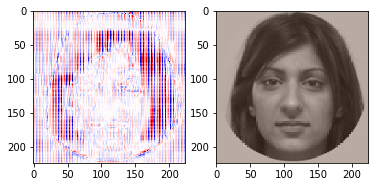

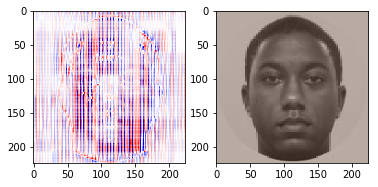

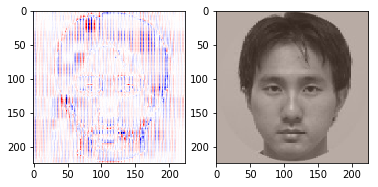

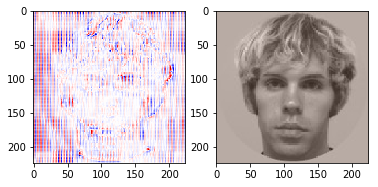

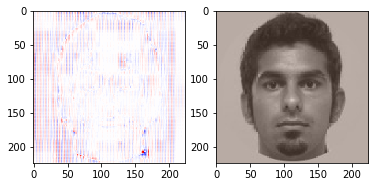

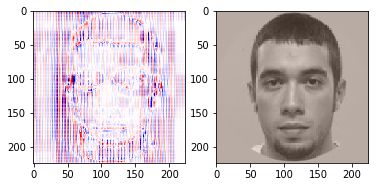

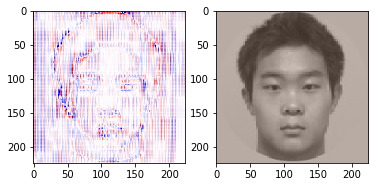

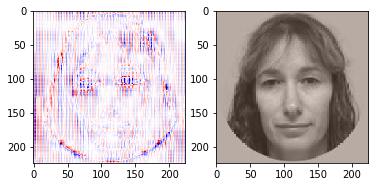

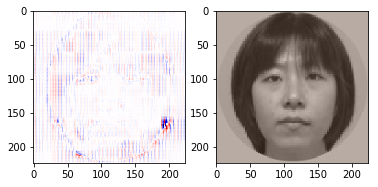

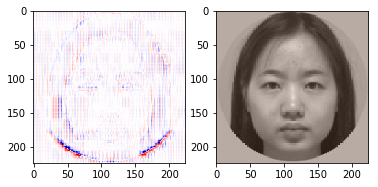

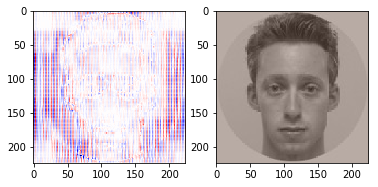

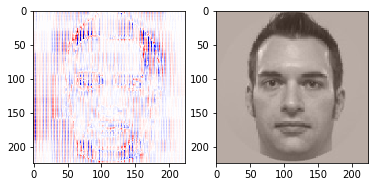

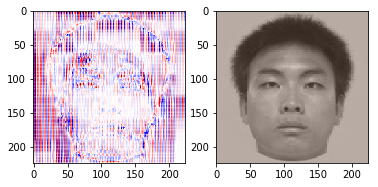

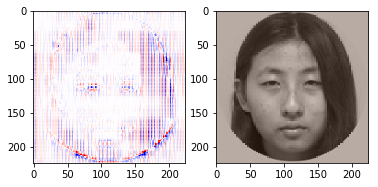

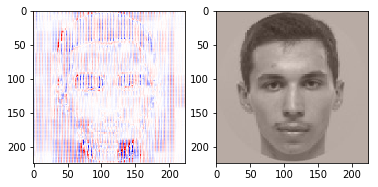

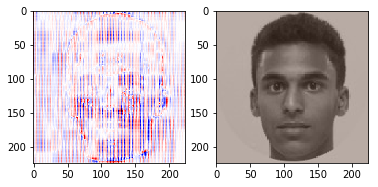

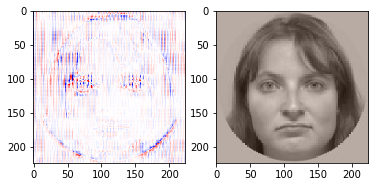

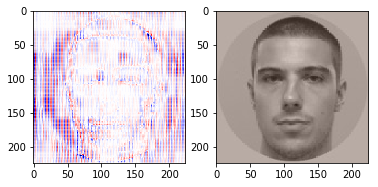

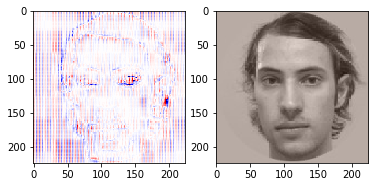

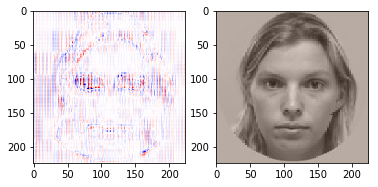

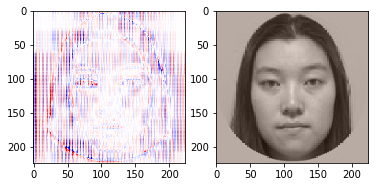

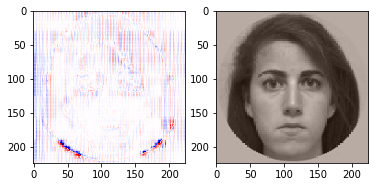

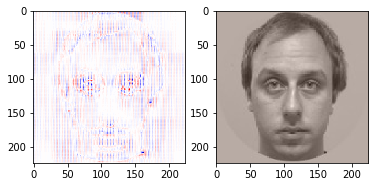

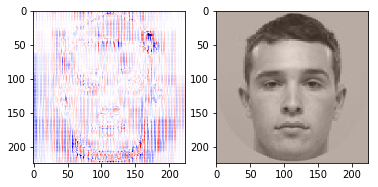

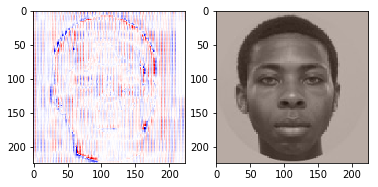

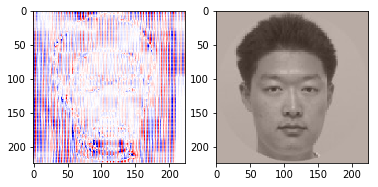

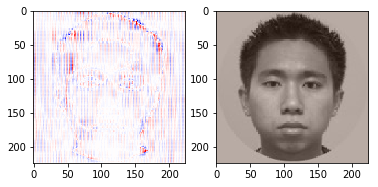

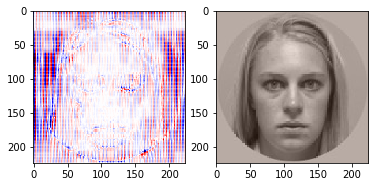

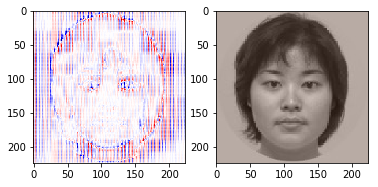

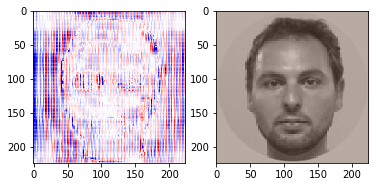

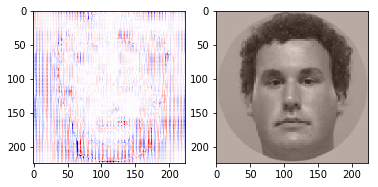

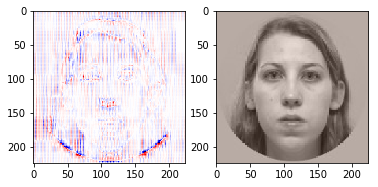

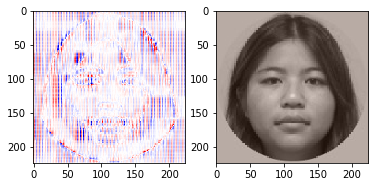

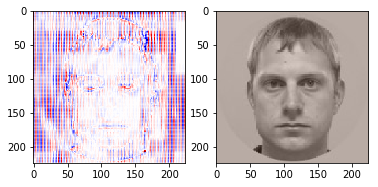

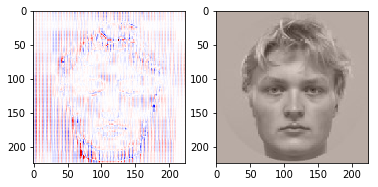

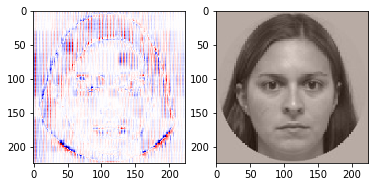

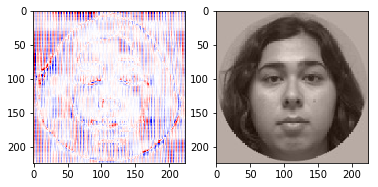

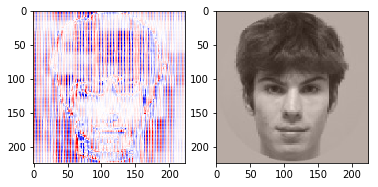

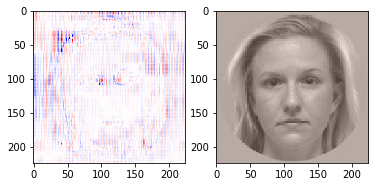

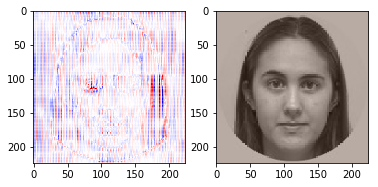

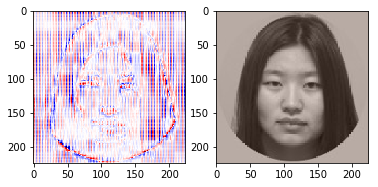

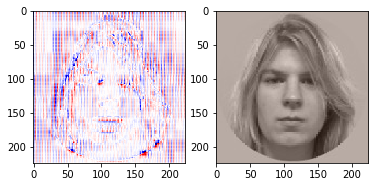

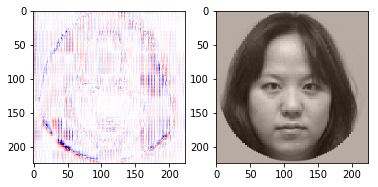

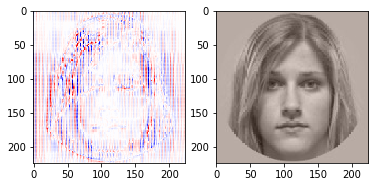

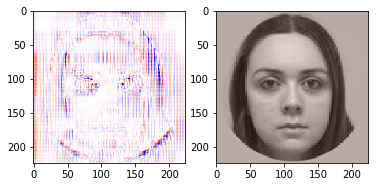

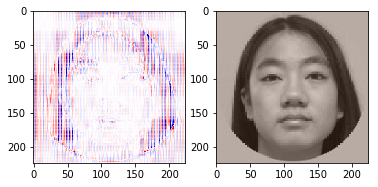

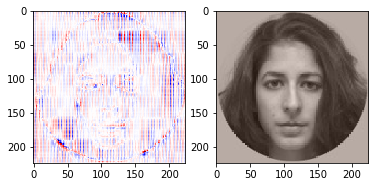

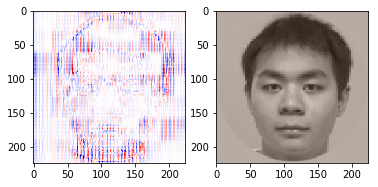

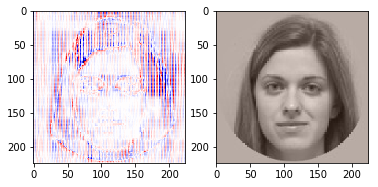

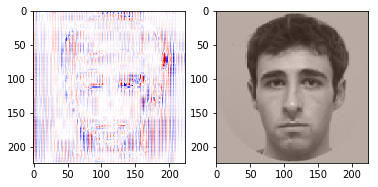

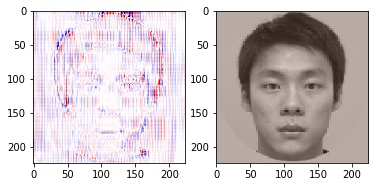

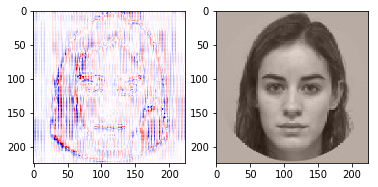

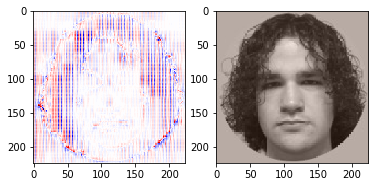

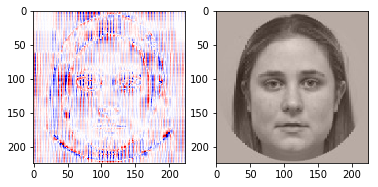

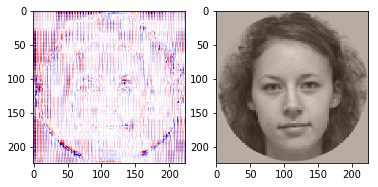

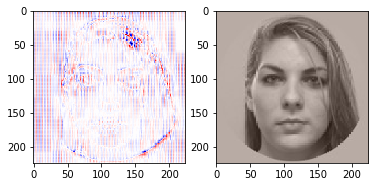

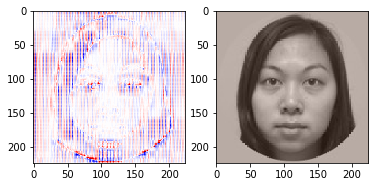

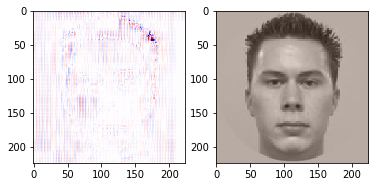

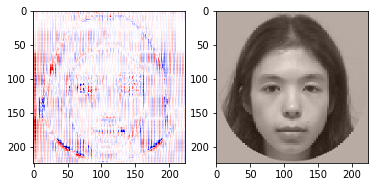

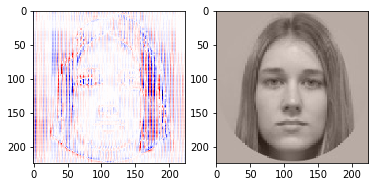

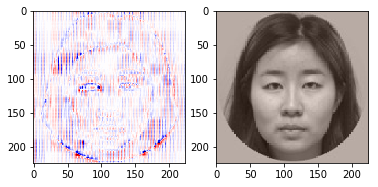

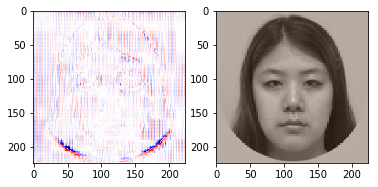

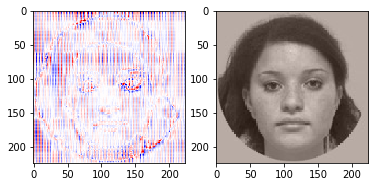

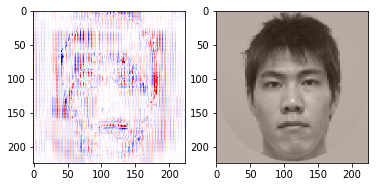

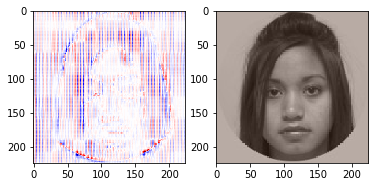

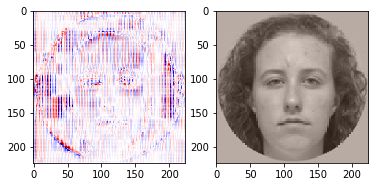

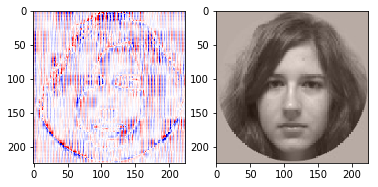

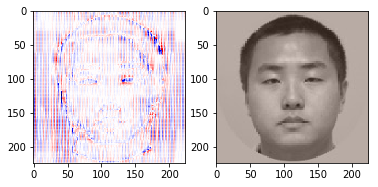

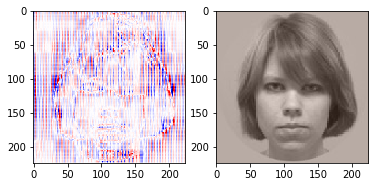

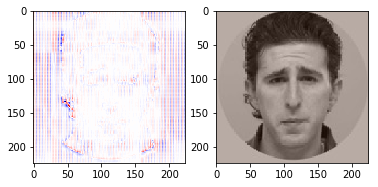

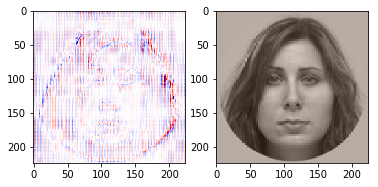

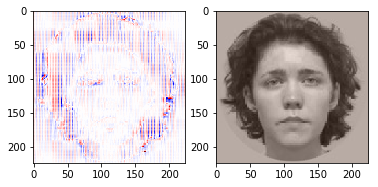

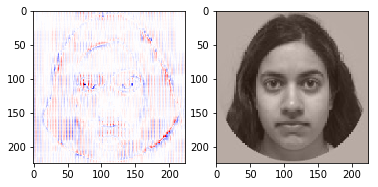

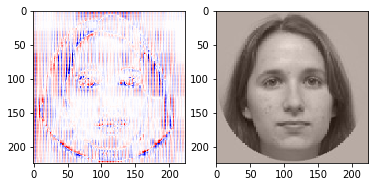

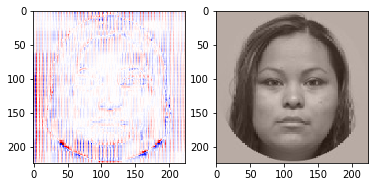

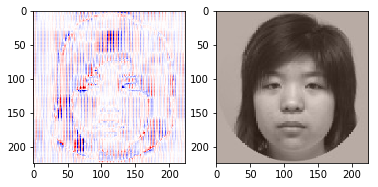

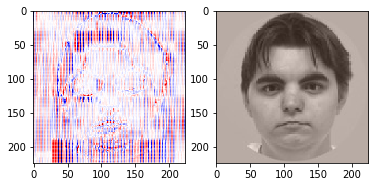

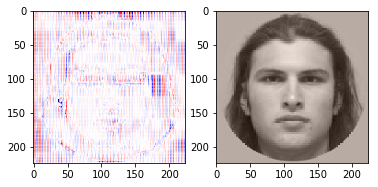

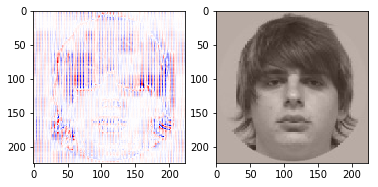

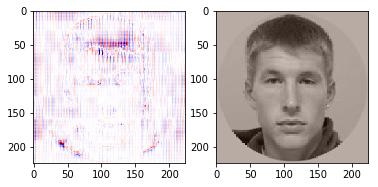

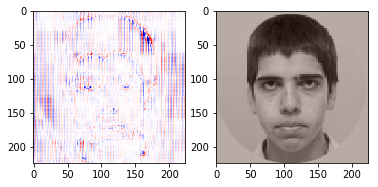

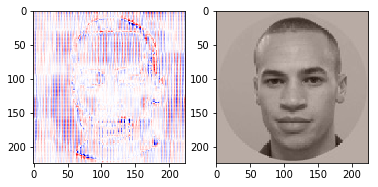

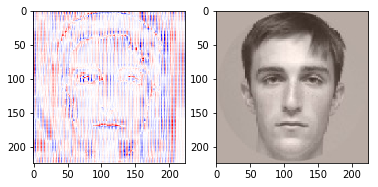

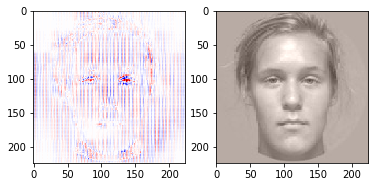

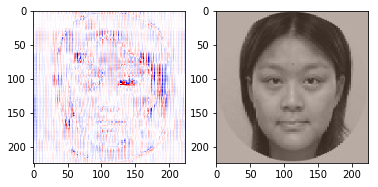

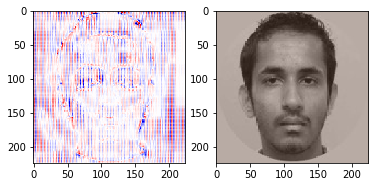

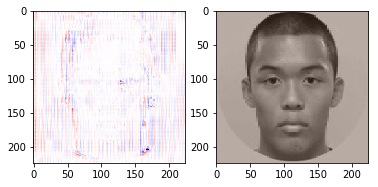

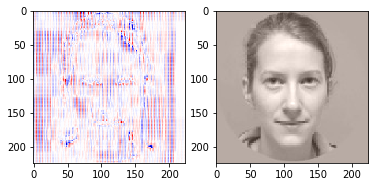

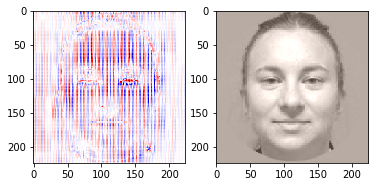

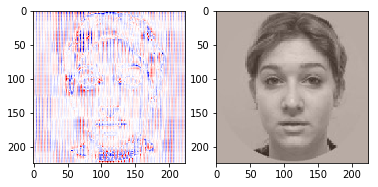

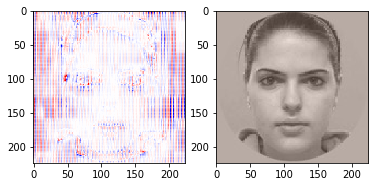

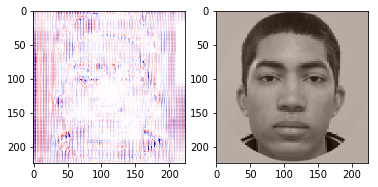

In [127]:
# Aggregate along color channels and normalize to [-1, 1]
for i in range(len(rs)):
    plt.figure()
    r = rs[i].sum(axis=3)
    r /= np.max(np.abs(r))
    plt.subplot(1,2,1)
    plt.imshow(r[0], cmap="seismic", clim=[-1,1])
    #plt.colorbar()
    plt.subplot(1,2,2)
    #weighted = batch[i]*np.expand_dims(np.abs(r[0]),-1)
    #weighted = weighted/255+0.5
    plt.imshow(batch[i]/255 + 0.5)

Calculate featurewise relevance statistics

1. Rectangular well-aligned masks

4.574084918189305 1.4144644360351237 2.5695363345592512 5.097727275851031
2.020904646321565 0.6739652056257734 1.0230437042366418 1.7279078444843374
0.0015246949727297683 0.0008840402725219525 0.0012235887307425006 0.0014160353544030641
0.0006736348821071884 0.0004212282535161084 0.00048716366868411517 0.0004799744012456493


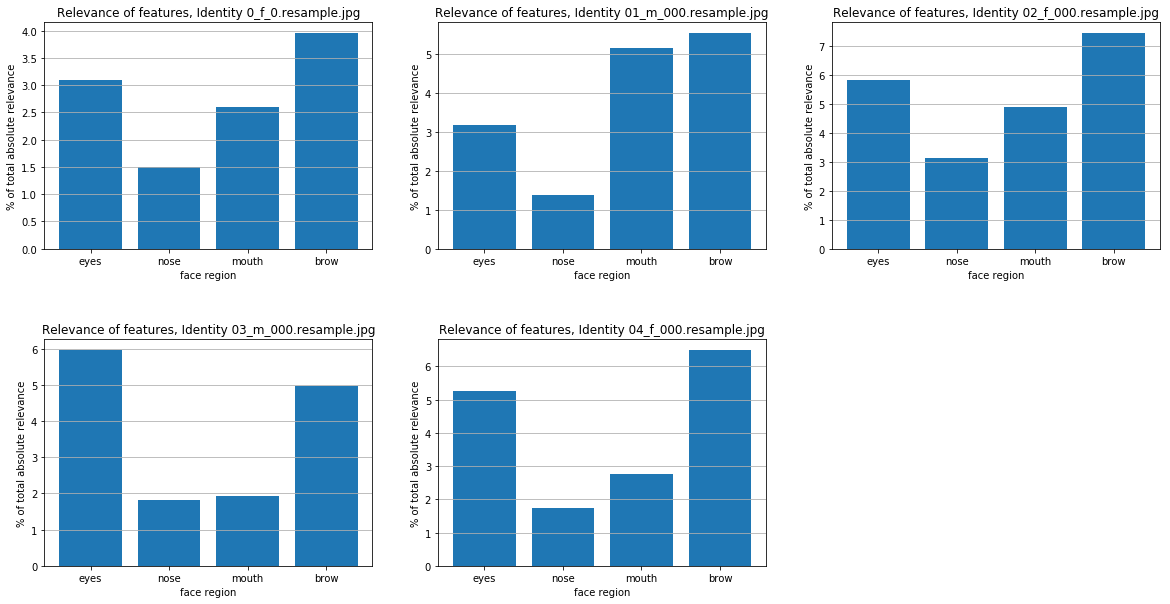

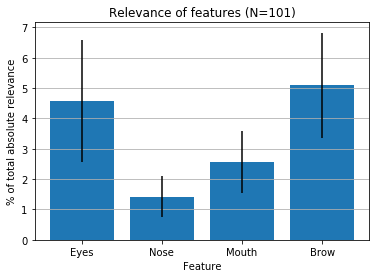

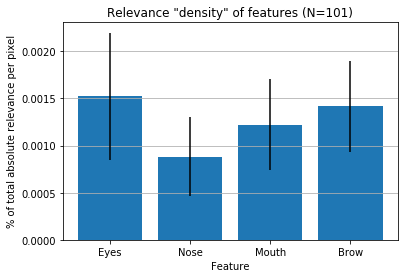

In [62]:
total, eyes, nose, mouth, brow, outside, inside = [], [], [], [] ,[], [], [];
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace = 0.4)
for i in range (len(rs)):
    g = rs[i][0]
    #print(len(rs))
    #print(front_view_filenames[i])
    total.append(np.sum(np.abs(g)))
    #print("total relevance:",total[i])
    eyes.append(np.sum(np.abs(g[100:130,60:160])) / total[i])
    #print("eyes relevance:",eyes[i])
    nose.append(np.sum(np.abs(g[120:160,90:130])) / total[i])
    #print("nose relevance:",nose[i])
    mouth.append(np.sum(np.abs(g[160:190,75:145])) / total[i])
    #print("mouth relevance:",mouth[i])
    brow.append(np.sum(np.abs(g[70:100,50:170])) / total[i])
    #print("brow relevance:",brow[i])
    
    outside.append(1-(eyes[i]+nose[i]+mouth[i]+brow[i]))
    inside.append((eyes[i]+nose[i]+mouth[i]+brow[i]))
    
    if i <= 4:
        plt.subplot(2,3,i+1)
        plt.title("Relevance of features, Identity "+front_view_filenames[i].split("/")[2])
        plt.bar(x=[ "eyes", "nose", "mouth", "brow"],height=[ eyes[i]*100, nose[i]*100, mouth[i]*100, brow[i]*100])
        plt.grid(axis='y')
        plt.xlabel('face region')
        plt.ylabel('% of total absolute relevance')
    
plt.figure()
plt.title("Relevance of features (N=101)")
plt.bar(x=[ "Eyes", "Nose", "Mouth", "Brow"],
        height=[ np.mean(eyes)*100,  np.mean(nose)*100,  np.mean(mouth)*100,  np.mean(brow)*100],
        yerr = [ np.std(eyes)*100,  np.std(nose)*100,  np.std(mouth)*100,  np.std(brow)*100])
plt.grid(axis='y')
plt.xlabel('Feature')
plt.ylabel('% of total absolute relevance');


peyes = np.sum(np.ones_like(rs[0][0][100:130,60:160,0]))
pnose = np.sum(np.ones_like(rs[0][0][120:160,90:130,0]))
pmouth = np.sum(np.ones_like(rs[0][0][160:190,75:145,0]))
pbrow = np.sum(np.ones_like(rs[0][0][70:100,50:170,0]))

plt.figure()
plt.title("Relevance \"density\" of features (N=101)")
plt.bar(x=[ "Eyes", "Nose", "Mouth", "Brow"],
        height=[ np.mean(eyes)/peyes*100,  np.mean(nose)/pnose*100,  np.mean(mouth)/pmouth*100,  np.mean(brow)/pbrow*100],
        yerr = [ np.std(eyes)/peyes*100,  np.std(nose)/pnose*100,  np.std(mouth)/pmouth*100,  np.std(brow)/pbrow*100])
plt.grid(axis='y')
plt.xlabel('Feature')
plt.ylabel('% of total absolute relevance per pixel');

print(np.mean(eyes)*100,  np.mean(nose)*100,  np.mean(mouth)*100,  np.mean(brow)*100)
print(np.std(eyes)*100,  np.std(nose)*100,  np.std(mouth)*100,  np.std(brow)*100)

print(np.mean(eyes)/peyes*100,  np.mean(nose)/pnose*100,  np.mean(mouth)/pmouth*100,  np.mean(brow)/pbrow*100)
print(np.std(eyes)/peyes*100,  np.std(nose)/pnose*100,  np.std(mouth)/pmouth*100,  np.std(brow)/pbrow*100)

2. Hand-drawn masks (using average face as a guide)

[ 6.11571348 28.46171829  2.84066547  1.4466658   1.58409711  4.49102285
  3.77161405]


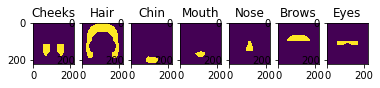

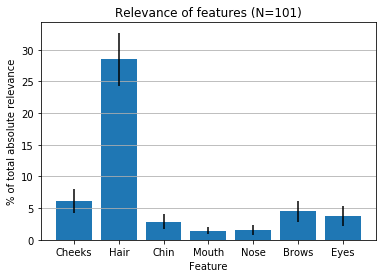

In [63]:
masks = []
features = ["Cheeks","Hair","Chin","Mouth","Nose","Brows","Eyes"]
results = []
pixels = []
densities = []

avg_rel_forward = np.mean(r,axis=0)
total = np.sum(np.abs(avg_rel_forward))
for i in range(len(features)):
    masks.append(np.mean(np.array(image_utils.load_img("./masks/mask_"+features[i].lower()+".png",target_size=(224, 224)))/255.0,axis=-1))
    plt.subplot(1,7,i+1)
    plt.imshow(masks[i])
    plt.title(features[i])

    pixels.append(np.sum(masks[i]))
    results.append([])
    densities.append([])
    for m in range(len(rs)):
        results[i].append(np.sum(np.abs(masks[i][:, :, None]*rs[m][0])/np.sum(np.abs(rs[m][0]))))
        densities[i].append(results[i][m]/pixels[i])
    
plt.figure()
plt.bar(x=features,
        height=100*np.mean(results, axis=-1), yerr=100*np.std(results, axis=-1))
plt.grid(axis='y')
plt.xlabel('Feature')
plt.ylabel('% of total absolute relevance');
plt.title("Relevance of features (N=101)")
print(100*np.mean(results, axis=-1))

[0.0013799  0.002062   0.0014449  0.00115641 0.00098208 0.00137508
 0.00165858]


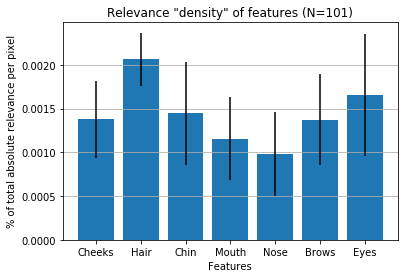

In [64]:
plt.figure()
plt.bar(x=features,
        height=100*np.mean(densities, axis=-1), yerr=100*np.std(densities, axis=-1))
plt.grid(axis='y')
plt.xlabel('Features')
plt.ylabel('% of total absolute relevance per pixel');
plt.title("Relevance \"density\" of features (N=101)")
print(100*np.mean(densities, axis=-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

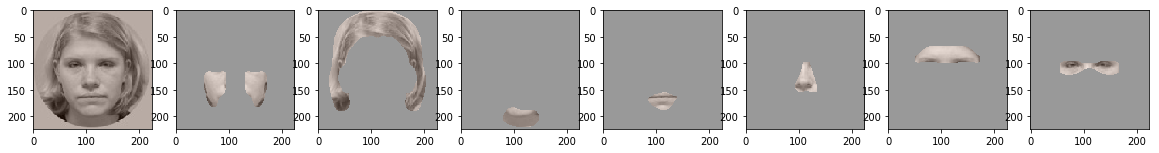

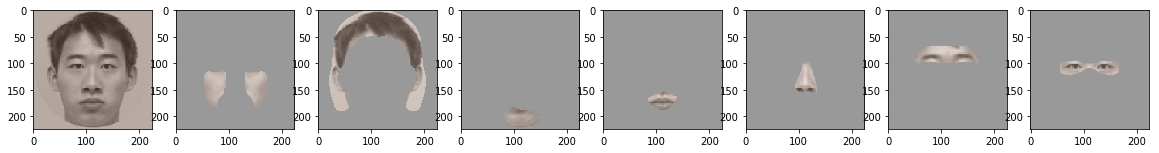

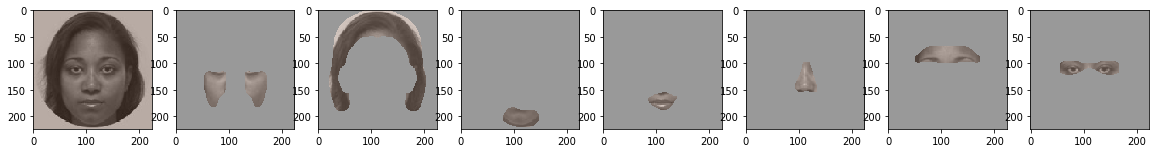

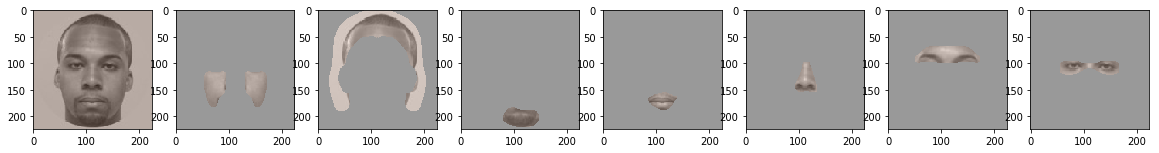

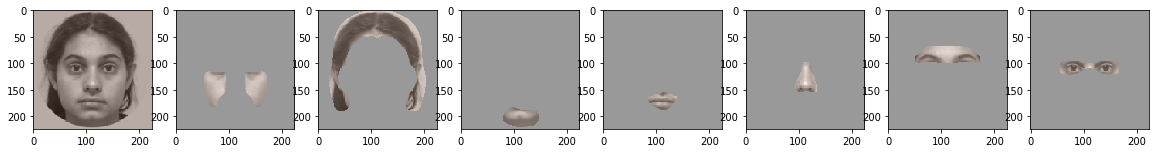

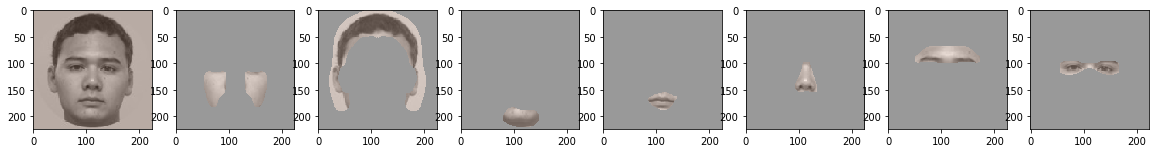

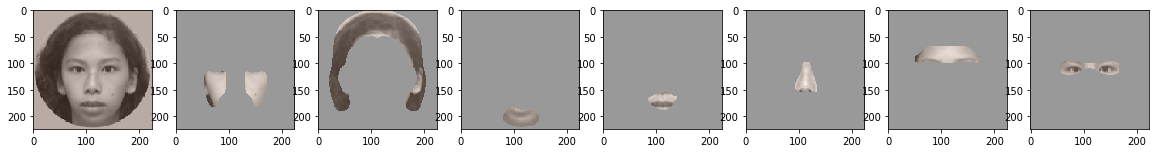

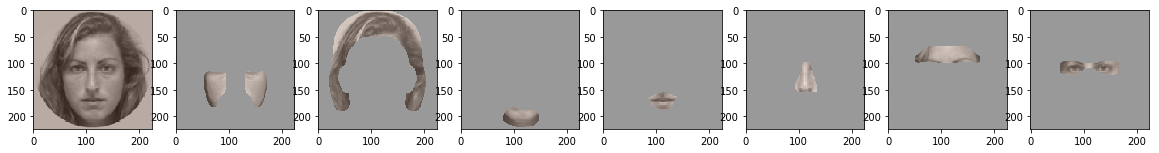

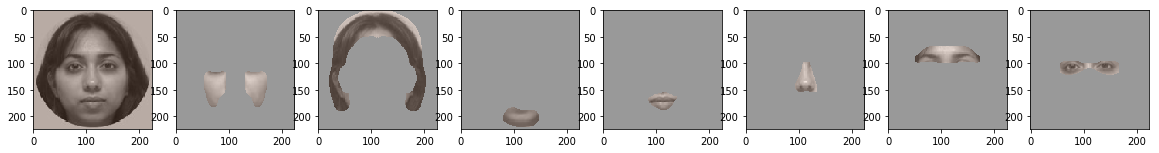

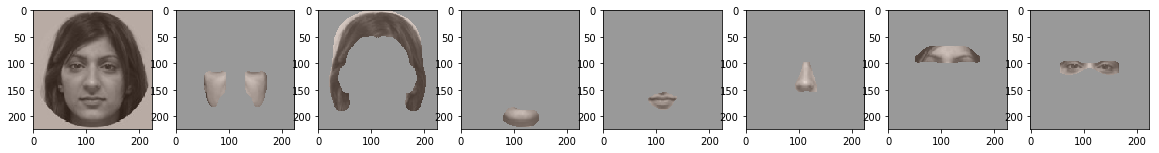

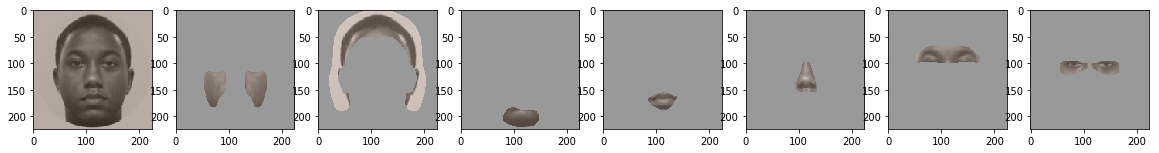

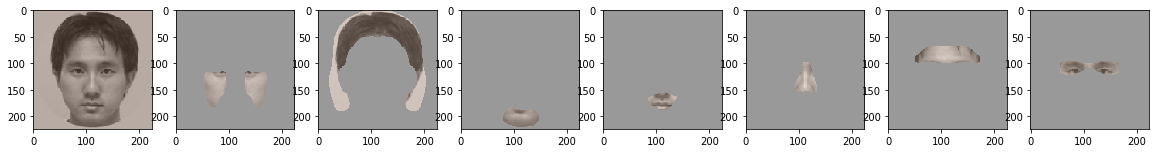

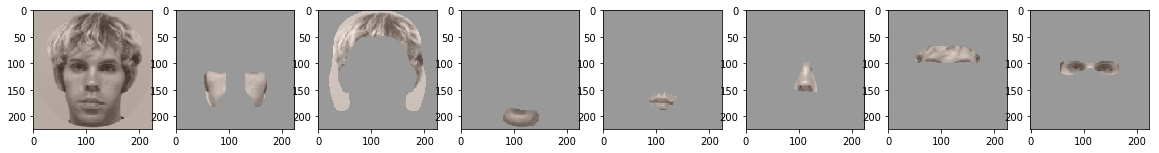

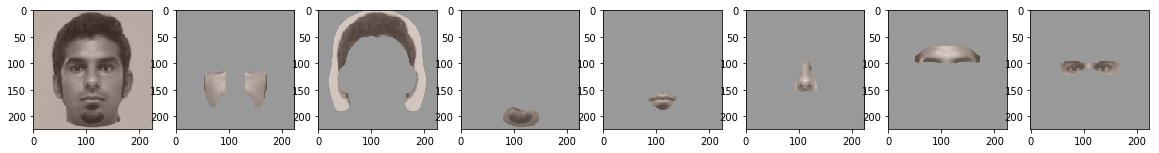

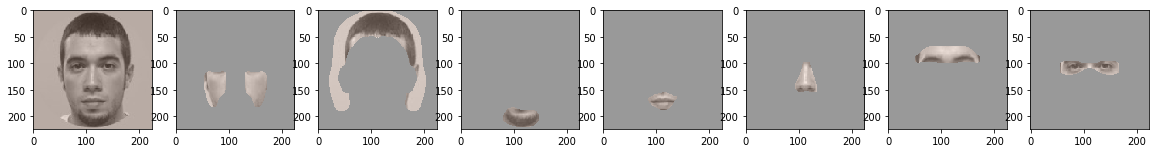

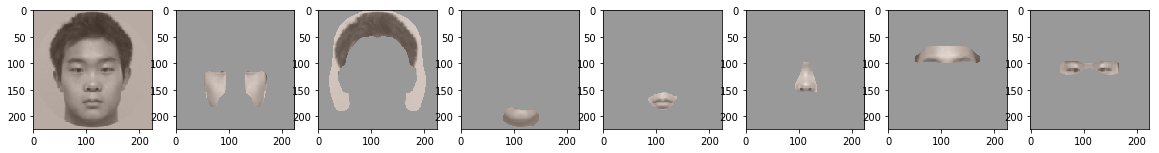

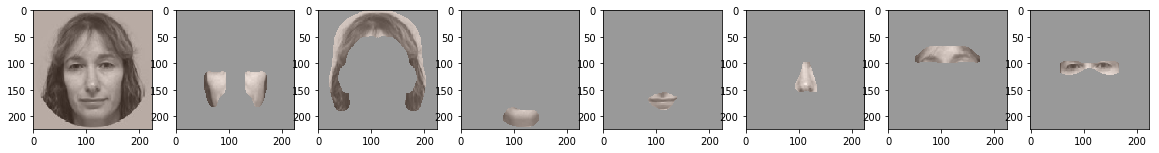

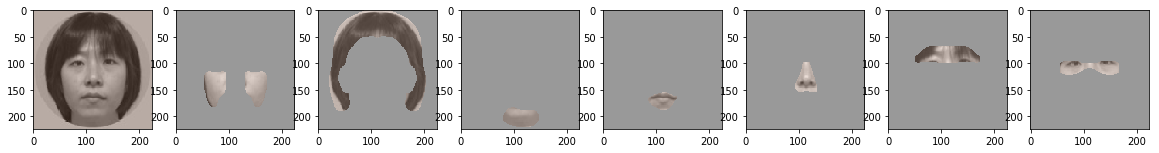

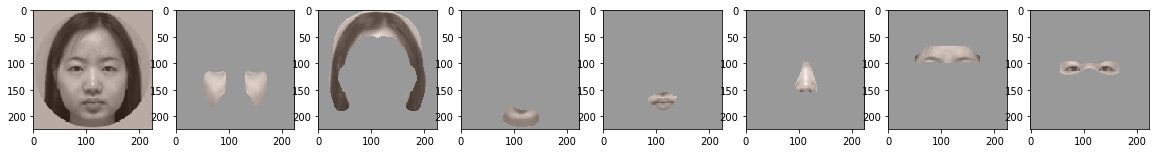

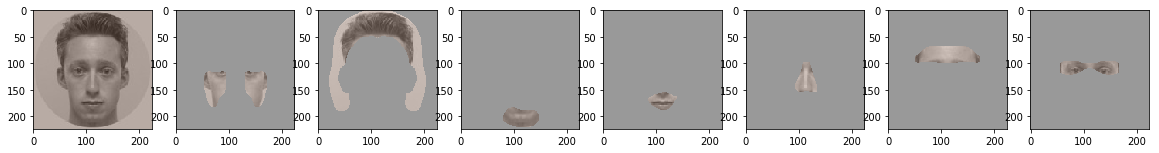

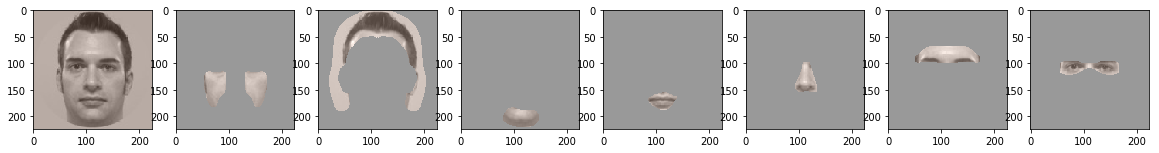

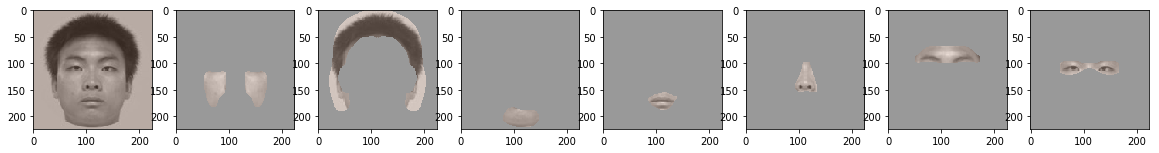

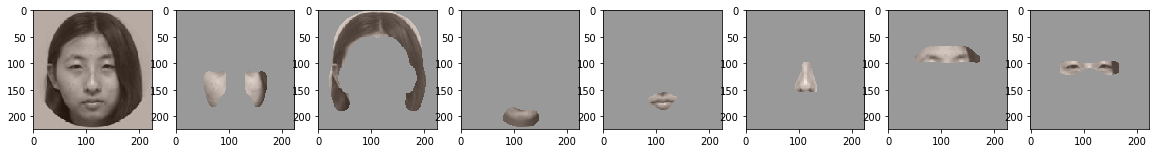

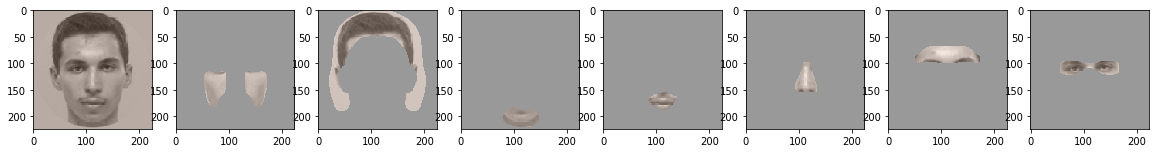

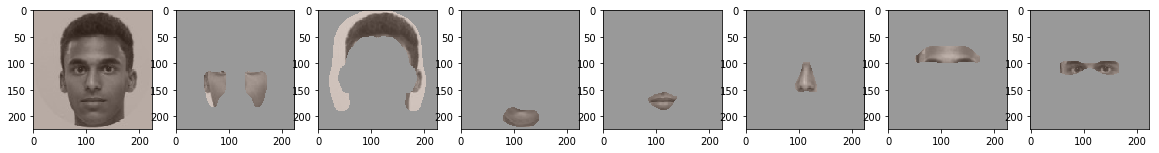

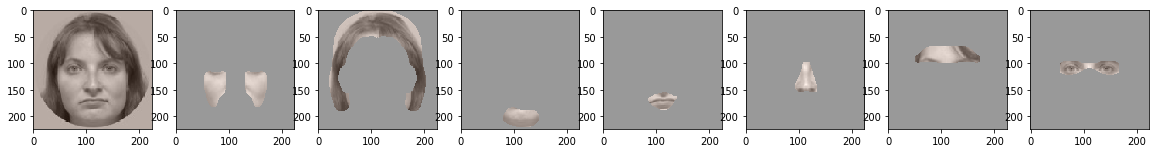

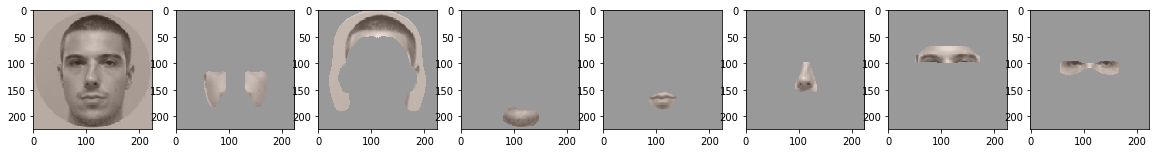

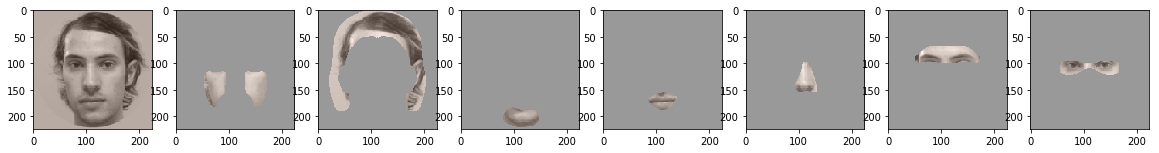

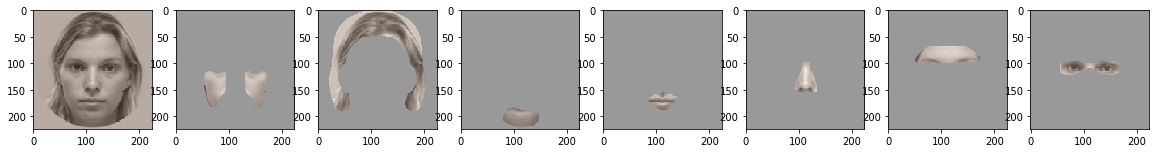

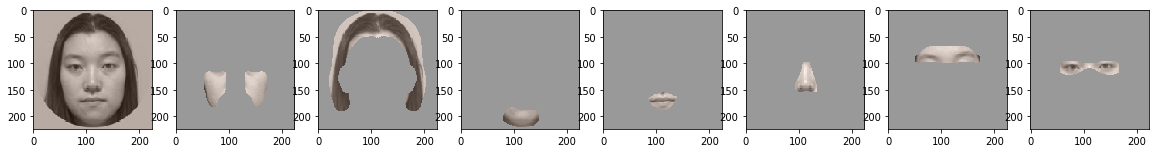

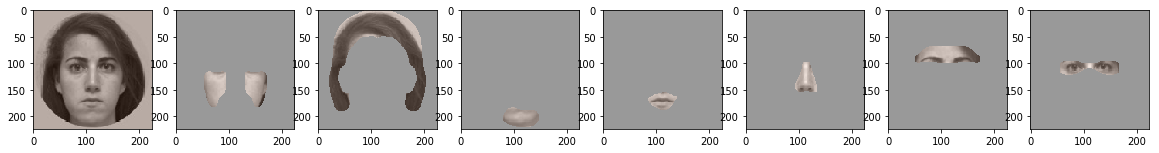

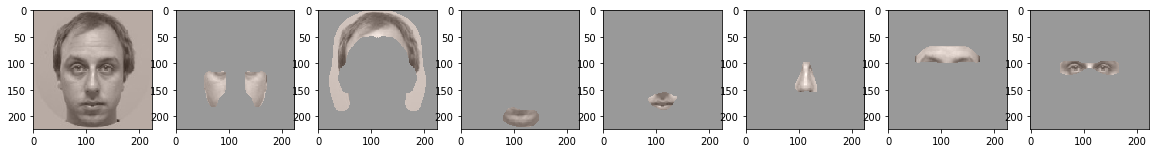

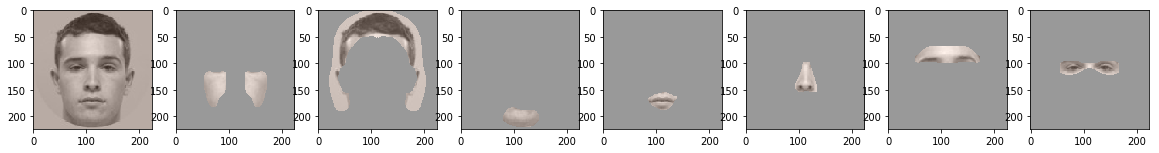

Error in callback <function flush_figures at 0x00000202CE7AAB70> (for post_execute):


KeyboardInterrupt: 

In [65]:
#view alignment of masks
for i in range(len(batch)):
    plt.figure(figsize=(20,3))
    plt.subplot(1,len(masks)+1,1)
    plt.imshow(batch[i]/255.0 + 0.5)
    for m in range(len(masks)):
        #plt.colorbar()
        plt.subplot(1,len(masks)+1,m+2)
        plt.imshow(masks[m][:,:,None]*batch[i]/255.0 + 0.6)

Internal vs External Features

Text(0.5, 1.0, 'Relevance of features vs. other image pixels')

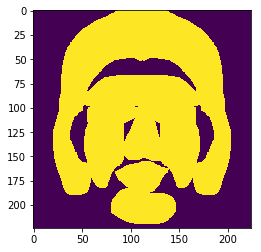

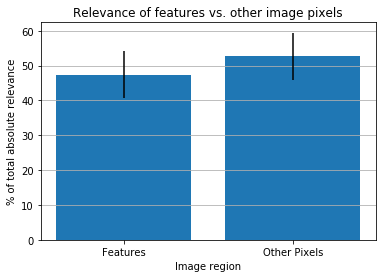

In [69]:
int_mask = np.zeros_like(masks[0])
for i in range(len(masks)):
    int_mask = np.minimum(1, int_mask + masks[i])
    
plt.imshow(int_mask)
plt.figure()
internal_frac=[]
external_frac=[]
for i in range(len(batch)):
    internal_frac.append(np.sum(np.abs(int_mask[:,:,None]*rs[i][0]))/np.sum(np.abs(rs[i][0])))
    external_frac.append(1-internal_frac[i])

plt.bar(x=[ "Features", "Other Pixels"],
        height=[ 100*np.mean(internal_frac),  100*np.mean(external_frac)], yerr = [ 100*np.std(internal_frac),  100*np.std(external_frac)])
plt.grid(axis='y')
plt.xlabel('Image region')
plt.ylabel('% of total absolute relevance');
plt.title("Relevance of features vs. other image pixels")

In [70]:
print(100*np.mean(internal_frac),  100*np.mean(external_frac))
print(100*np.std(internal_frac),  100*np.std(external_frac))

47.407538565261575 52.592461434738425
6.82417711863674 6.82417711863674


In [ ]:
plt.figure()
r = rs[74].sum(axis=3)
r /= np.max(np.abs(r))
plt.imshow(r[0], cmap="seismic", clim=[-1,1])
plt.colorbar()
plt.figure()
plt.imshow(batch[74]/255 + 0.5)

Sonia's Masks

[ 7.81432656  1.96326146  5.58478116 48.16177805  1.23217343]


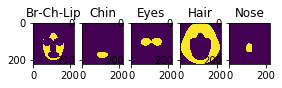

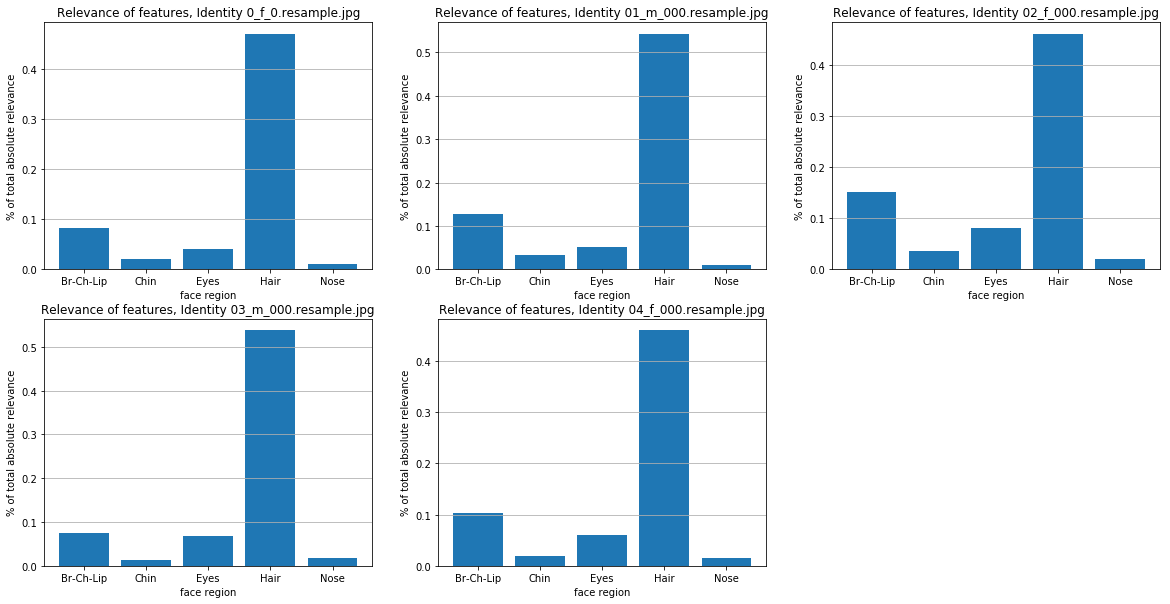

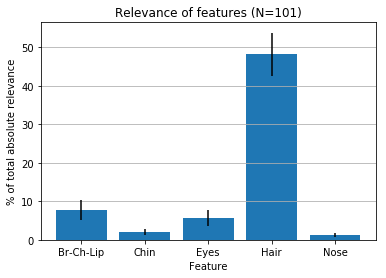

In [147]:
masks = []
features = ["Br-Ch-Lip","Chin","Eyes","Hair","Nose"]
results = []
pixels = []
densities = []

avg_rel_forward = np.mean(r,axis=0)
total = np.sum(np.abs(avg_rel_forward))
for i in range(len(features)):
    masks.append(np.mean(np.array(image_utils.load_img("./masks/sonia/mask-"+features[i].lower()+".png",target_size=(224, 224)))/255.0,axis=-1))
    plt.subplot(1,7,i+1)
    plt.imshow(masks[i])
    plt.title(features[i])

    pixels.append(np.sum(masks[i]))
    results.append([])
    densities.append([])
    for m in range(len(rs)):
        results[i].append(np.sum(np.abs(masks[i][:, :, None]*rs[m][0])/np.sum(np.abs(rs[m][0]))))
        densities[i].append(results[i][m]/pixels[i])

plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.title("Relevance of features, Identity "+front_view_filenames[i].split("/")[2])
    plt.bar(x=features,height=[f[i] for f in results])
    plt.grid(axis='y')
    plt.xlabel('face region')
    plt.ylabel('% of total absolute relevance')
    
plt.figure()
plt.bar(x=features,
        height=100*np.mean(results, axis=-1), yerr=100*np.std(results, axis=-1))
plt.grid(axis='y')
plt.xlabel('Feature')
plt.ylabel('% of total absolute relevance');
plt.title("Relevance of features (N=101)")
print(100*np.mean(results, axis=-1))

[0.00131474 0.00119125 0.00151945 0.0020221  0.00090216]


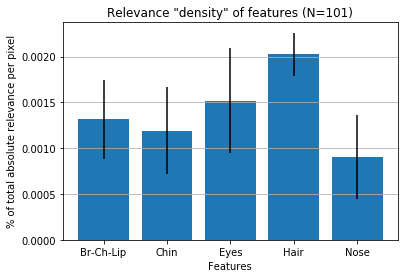

In [148]:
plt.figure()
plt.bar(x=features,
        height=100*np.mean(densities, axis=-1), yerr=100*np.std(densities, axis=-1))
plt.grid(axis='y')
plt.xlabel('Features')
plt.ylabel('% of total absolute relevance per pixel');
plt.title("Relevance \"density\" of features (N=101)")
print(100*np.mean(densities, axis=-1))

Export relevances to (*gag*) matlab 

In [128]:
for i in range(len(rs)):
    scipy.io.savemat("./relevances_matlab/"+str(i)+".mat",{"relevance":rs[i]})

# Inverted faces

(101, 224, 224, 3)
(101, 224, 224, 3)


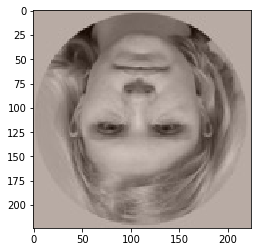

In [129]:
inverted_batch = np.array([np.flipud(m) for m in batch])
plt.figure()
plt.imshow(inverted_batch[0]/255 + 0.5)

print(batch.shape)
print(inverted_batch.shape)

In [130]:
inverted_relevances = relevanceMap(inverted_batch)

Analysing image 1 of 101 ...


c:\users\jnani\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
c:\users\jnani\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


ETA: Sun Aug 25 10:20:47 2019
Analysing image 2 of 101 ...
ETA: Sun Aug 25 10:21:58 2019
Analysing image 3 of 101 ...
ETA: Sun Aug 25 10:17:33 2019
Analysing image 4 of 101 ...
ETA: Sun Aug 25 10:24:34 2019
Analysing image 5 of 101 ...
ETA: Sun Aug 25 10:19:50 2019
Analysing image 6 of 101 ...
ETA: Sun Aug 25 10:16:01 2019
Analysing image 7 of 101 ...
ETA: Sun Aug 25 10:14:17 2019
Analysing image 8 of 101 ...
ETA: Sun Aug 25 10:17:17 2019
Analysing image 9 of 101 ...
ETA: Sun Aug 25 10:17:25 2019
Analysing image 10 of 101 ...
ETA: Sun Aug 25 10:21:33 2019
Analysing image 11 of 101 ...
ETA: Sun Aug 25 10:20:23 2019
Analysing image 12 of 101 ...
ETA: Sun Aug 25 10:22:04 2019
Analysing image 13 of 101 ...
ETA: Sun Aug 25 10:23:42 2019
Analysing image 14 of 101 ...
ETA: Sun Aug 25 10:22:12 2019
Analysing image 15 of 101 ...
ETA: Sun Aug 25 10:21:50 2019
Analysing image 16 of 101 ...
ETA: Sun Aug 25 10:23:57 2019
Analysing image 17 of 101 ...
ETA: Sun Aug 25 10:21:16 2019
Analysing image 18

In [131]:
for i in range(len(inverted_relevances)):
    np.savez("./relevances_inverted/rmap"+str(i)+".npz", inverted_relevances[i])

In [132]:
rsi = []
for i in range(101):
    rsi.append(list(np.load("./relevances_inverted/rmap"+str(i)+".npz").values())[0])

In [134]:
for i in range(len(rsi)):
    scipy.io.savemat("./relevances_inverted_matlab/"+str(i)+".mat",{"relevance":rs[i]})

In [ ]:
# Aggregate along color channels and normalize to [-1, 1]
for i in range(len(rsi)):
    plt.figure()
    r = rsi[i].sum(axis=3)
    r /= np.max(np.abs(r))
    plt.subplot(1,2,1)
    plt.imshow(r[0], cmap="seismic", clim=[-1,1])
    #plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(inverted_batch[i]/255 + 0.5)

[ 7.52769408  2.58874069  3.60574572 44.32689987  1.4269891 ]


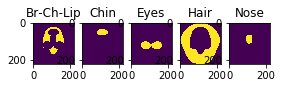

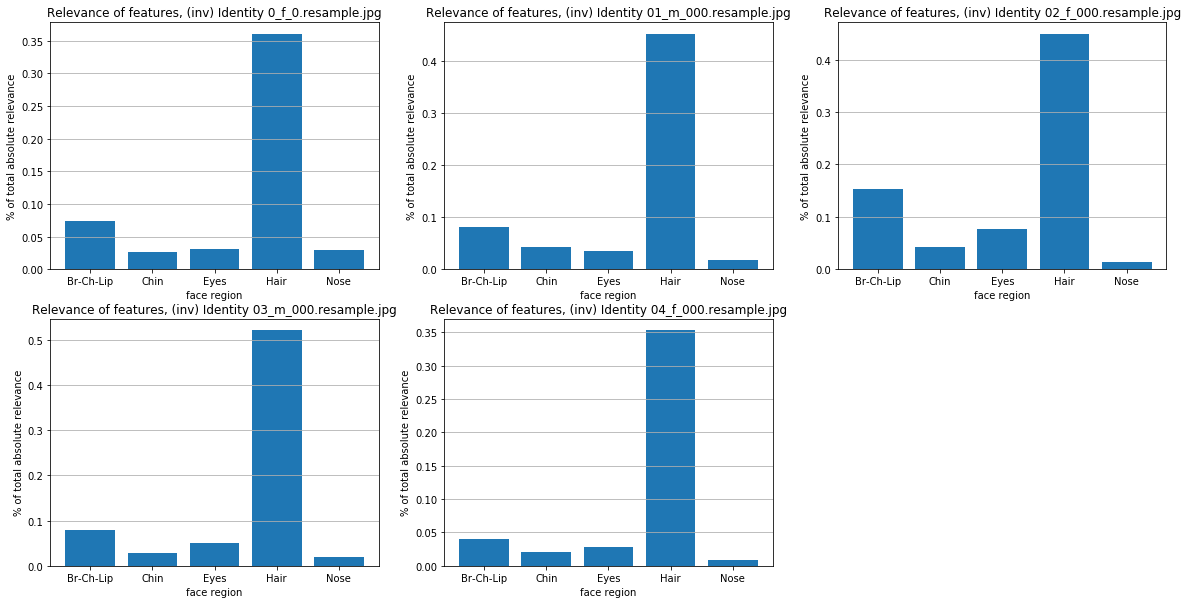

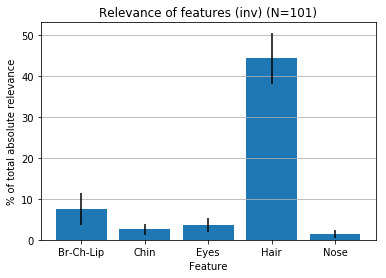

In [149]:
masks = []
ifeatures = ["iBr-Ch-Lip","iChin","iEyes","iHair","iNose"]
iresults = []
pixels = []
idensities = []

avg_rel_forward = np.mean(r,axis=0)
total = np.sum(np.abs(avg_rel_forward))
for i in range(len(features)):
    masks.append(np.flipud(np.mean(np.array(image_utils.load_img("./masks/sonia/mask-"+features[i].lower()+".png",target_size=(224, 224)))/255.0,axis=-1)))
    plt.subplot(1,7,i+1)
    plt.imshow(masks[i])
    plt.title(features[i])

    pixels.append(np.sum(masks[i]))
    iresults.append([])
    idensities.append([])
    for m in range(len(rsi)):
        iresults[i].append(np.sum(np.abs(masks[i][:, :, None]*rsi[m][0])/np.sum(np.abs(rsi[m][0]))))
        idensities[i].append(iresults[i][m]/pixels[i])

plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.title("Relevance of features, (inv) Identity "+front_view_filenames[i].split("/")[2])
    plt.bar(x=features,height=[f[i] for f in iresults])
    plt.grid(axis='y')
    plt.xlabel('face region')
    plt.ylabel('% of total absolute relevance')
    
plt.figure()
plt.bar(x=features,
        height=100*np.mean(iresults, axis=-1), yerr=100*np.std(iresults, axis=-1))
plt.grid(axis='y')
plt.xlabel('Feature')
plt.ylabel('% of total absolute relevance');
plt.title("Relevance of features (inv) (N=101)")
print(100*np.mean(iresults, axis=-1))

[0.00126652 0.00157077 0.00098101 0.00186109 0.0010448 ]


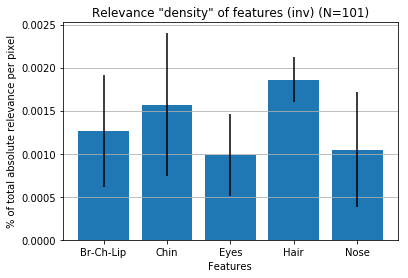

In [150]:
plt.figure()
plt.bar(x=features,
        height=100*np.mean(idensities, axis=-1), yerr=100*np.std(idensities, axis=-1))
plt.grid(axis='y')
plt.xlabel('Features')
plt.ylabel('% of total absolute relevance per pixel');
plt.title("Relevance \"density\" of features (inv) (N=101)")
print(100*np.mean(idensities, axis=-1))

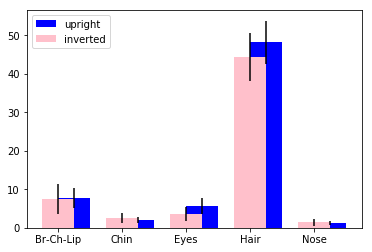

In [158]:
plt.figure()
ax = plt.subplot(111)
ax.bar(features, height=100*np.mean(results, axis=-1), yerr=100*np.std(results, axis=-1), width=0.5, color='b', align='edge')
ax.bar(features, height=100*np.mean(iresults, axis=-1), yerr=100*np.std(iresults, axis=-1), width=0.5, color='pink', align='center')
plt.legend(["upright","inverted"])
plt.show()